In [1]:
import numpy as np
import load_from_snapshot
import h5py
from matplotlib import pyplot as plt
import pickle
import os
from os import system, mkdir, chdir
from glob import glob
from os.path import isdir
import numpy as np
import itertools
from matplotlib.colors import ListedColormap
from matplotlib import cm

<ipython-input-108-c53d2ae7d3ba>:86: RuntimeWarning: invalid value encountered in double_scalars
  mStarFrac.append(tenPNum/mStarNum)


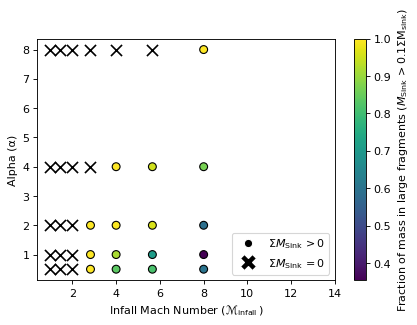

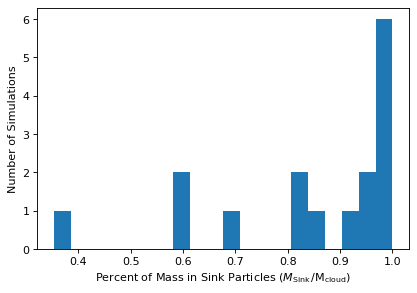

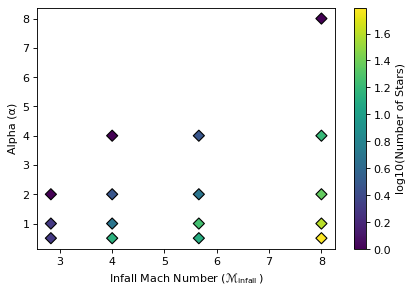

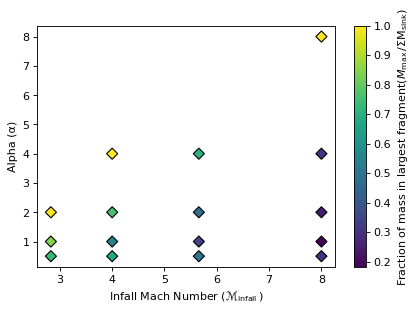

In [108]:
### This is the interesting part. It makes a .txt file for data dumping and also makes pretty cool graphs.
### The histogram is inaccurate as some values of "nan" occur when division by zero occurs. The zero bar graph
### should be taller.
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # white background with .png images
    "figure.dpi": 80
})

chdir("/home/hlane/project1Sims/allPickle")

infall_machs = np.logspace(0,3,7,base=2) # the list of infall mach #'s we want - ranges from 1 to 8, evenly spaced in log space (each is a certain % larger than the last, in a geometric progression)
alphas = 0.5, 1, 2, 4, 8 #list of turbulent virial parameters we want - 0 is no initial turbulence 0, 0.5, 1, 2, 4, 8
mus = 4, #np.inf, 4, 2, 1, 0.5, 0.25  # list of mass-to-flux ratios (greek letter mu) that we want - infinity is no magnetic field, ~0 is very strong magnetic field
seeds = 42, #42, 2, 3 # different initial turbulent seed fields - so that we try a few different random samplings of the initial turbulence to make sure results are not a fluke
sol_fracs = 0.5,  # 0, 1 # fraction of turbulent field in solenoidal modes 

machList = []
alphaList = []
markerList = []

machDict = {}
alphaDict = {}
markerDict = {}

tenPercentList = [] 
initMachList = []
infall_machList = []
mStarFrac = []
colorList = []
starColorCount = []
maxStar = []
for infall_mach in infall_machs:
    for alpha in alphas:
        for mu in mus:
            for seed in seeds:                
                for sol_frac in sol_fracs:

                    Ngas = max(100 * infall_mach**4, 10000)
                    run_name = "mach%g_alpha%g_mu%g_sol%g_Res%d_%d"%(round(infall_mach,2), round(alpha,2), round(mu,2), sol_frac, round(Ngas**(1./3)), seed) # this will be the unique identifier for the run - will want to create a new directory with this name
                    
                    machDict[run_name] = {}
                    alphaDict[run_name] = {}
                    markerDict[run_name] = {}

                    F=open(run_name + '.pickle', "rb")
                    temp = pickle.load(F)
                    tenPercentMassesList = temp[0]
                     # pickle
                    mStarList = temp[1]              # pickle
                    numTot = temp[2]                 # pickle
                    mCloudInit = temp[3]             # pickle

                    for i in range(numTot,numTot+1):
                        try:
                            tenPercentMass = np.sum(tenPercentMassesList[run_name][i])
                        except:
                            tenPercentMass = np.sum(tenPercentMassesList[run_name][0])
                        initMach = infall_mach * np.sqrt(alpha * 3/5)
                        tenPNum = tenPercentMass
                        try:
                            mStarNum = np.array(np.sum(mStarList[run_name][i]))
                        except:
                            mStarNum = np.array(np.sum(mStarList[run_name][i][0]))
                        try:
                            mStarListFixed = mStarList[run_name][i][0]
                        except:
                            mStarListFixed = mStarList[run_name][i]
                        sfe = mStarNum / mCloudInit
                        try:
                            if(max(mStarListFixed) > 0):
                                maxStar.append(max(mStarListFixed)/mStarNum)
                        except:
                            pass 

                        if(mStarNum > 0):
                            sinkPercent = tenPNum/mStarNum
                        else:
                            sinkPercent = 0
                        try:
                            if(sinkPercent < 0.10):
                                plt.scatter(infall_mach, alpha, c = "black", s = 100, marker = "x")
                                mStarFrac.append(tenPNum/mStarNum)
                            else:
                                initMachList.append(initMach)
                                infall_machList.append(infall_mach)
                                alphaList.append(alpha)
                                mStarFrac.append(tenPNum/mStarNum)
                                colorList.append(tenPNum/mStarNum)
                                starCount = np.log10(len(mStarListFixed))
                                starColorCount.append(starCount)
                        except:
                            mStarFrac.append(0)
                            print("You should not be seeing this message but its here as a way to fix something")
                            starColorCount.append(starCount)
                        sCount = len(mStarListFixed)
                        try:
                            sfrac = (max(mStarListFixed)/mStarNum)
                        except:
                            sfrac = 0
                        
                        with open("textDataDump", "ab") as G:
                            np.savetxt(G, np.array([[infall_mach, alpha, mu, sol_frac, sfe, sfrac, tenPercentMass, sCount]]))



                    F.close()

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker = '.', color='w', lw=4, label="$\Sigma$" + r"$M_{\rm Sink}\, \rm > 0$", markerfacecolor='black', markersize=15),
                   Line2D([0], [0], marker='X', color='w', label="$\Sigma$" + r"$M_{\rm Sink}\, \rm = 0$",
                          markerfacecolor='black', markersize=15)]

plt.scatter(infall_machList, alphaList, c = colorList, s = 50, alpha = 1.0, edgecolors = "black")
plt.xlabel("Infall Mach Number " + r"$(ℳ_{\rm infall}\, \rm$)")
plt.ylabel("Alpha (α)")
plt.xlim(0.4, 14)
cbar = plt.colorbar()
plt.legend(handles=legend_elements, loc='lower right')
cbar.set_label("Fraction of mass in large fragments (" + r"$M_{\rm Sink}\, \rm > 0.1\Sigma M_{\rm sink}$)")
plt.show()
plt.hist(mStarFrac, bins = 20)
plt.xlabel("Percent of Mass in Sink Particles (" + r"$M_{\rm Sink}\, \rm / M_{\rm cloud}$)")
plt.ylabel("Number of Simulations")
plt.show()
plt.scatter(infall_machList, alphaList, c = starColorCount, marker = 'D', s = 50, edgecolors = "black")
cbar = plt.colorbar()
plt.xlabel("Infall Mach Number " + r"$(ℳ_{\rm infall}\, \rm$)")
#plt.xlabel("Initial Turbulent Mach Number " + "(ℳ)")
plt.ylabel("Alpha (α)")
cbar.set_label("log10(Number of Stars)")

plt.show()
plt.scatter(infall_machList, alphaList, c = maxStar, marker = 'D', s = 50, edgecolors = "black")
cbar = plt.colorbar()
plt.xlabel("Infall Mach Number " + r"$(ℳ_{\rm infall}\, \rm$)")
#plt.xlabel("Initial Turbulent Mach Number " + "(ℳ)")
plt.ylabel("Alpha (α)")
cbar.set_label("Fraction of mass in largest fragment(" + r"$M_{\rm max}\, \rm / \Sigma M_{\rm sink}$)")
plt.show()

In [ ]:
### This section is broken at the moment. See above code for fixes that are relevant. 
### This code isn't too important and isn't useful atm so I'll fix it later if I need to


chdir("/home/hlane/project1Sims/allPickle")

infall_machs = np.logspace(0,3,7,base=2) # the list of infall mach #'s we want - ranges from 1 to 8, evenly spaced in log space (each is a certain % larger than the last, in a geometric progression)
alphas = 0.5, 1, 2, 4, 8 #list of turbulent virial parameters we want - 0 is no initial turbulence 0, 0.5, 1, 2, 4, 8
mus = 4, #np.inf, 4, 2, 1, 0.5, 0.25  # list of mass-to-flux ratios (greek letter mu) that we want - infinity is no magnetic field, ~0 is very strong magnetic field
seeds = 42, #42, 2, 3 # different initial turbulent seed fields - so that we try a few different random samplings of the initial turbulence to make sure results are not a fluke
sol_fracs = 0.5,  # 0, 1 # fraction of turbulent field in solenoidal modes 

for infall_mach in infall_machs:
    for alpha in alphas:
        for mu in mus:
            for seed in seeds:                
                for sol_frac in sol_fracs:
                    Ngas = max(100 * infall_mach**4, 10000)
                    run_name = "mach%g_alpha%g_mu%g_sol%g_Res%d_%d"%(round(infall_mach,2), round(alpha,2), round(mu,2), sol_frac, round(Ngas**(1./3)), seed) # this will be the unique identifier for the run - will want to create a new directory with this name
                    F=open(run_name + '.pickle', "rb")
                    temp = pickle.load(F)
                    tenPercentFractionDict = temp[0]
                    mStarTotalDict = temp[1]
                    numTot = temp[2]
                    mCloudInit = temp[3]
                    for i in range(numTot,numTot+1):
                        plt.scatter(infall_mach,tenPercentFractionDict[run_name][i])
                        print(tenPercentFractionDict[run_name][i])
                    F.close()
plt.title(alpha)
plt.xlabel("Infall Mach Number " + r"($ℳ_{\rm infall}\rm$)")
plt.ylabel("Fraction of mass in large fragments (" + r"$M_{\rm Sink}\, \rm > 0.1M_{\rm cloud}$)")
plt.show()